In [1]:
from typing import Callable

import tensorcircuit as tc
import tensorflow as tf

K = tc.set_backend("tensorflow")


def angle_embedding(c: tc.Circuit, inputs):
    num_qubits = inputs.shape[-1]

    for j in range(num_qubits):
        c.rx(j, theta=inputs[j])


def basic_vqc(c: tc.Circuit, inputs, weights):
    num_qubits = inputs.shape[-1]
    num_qlayers = weights.shape[-2]

    for i in range(num_qlayers):
        for j in range(num_qubits):
            c.rx(j, theta=weights[i, j])
        if num_qubits == 2:
            c.cnot(0, 1)
        elif num_qubits > 2:
            for j in range(num_qubits):
                c.cnot(j, (j + 1) % num_qubits)
        c.barrier_instruction(list(range(num_qubits)))


def get_quantum_layer_circuit(
    inputs, weights, embedding: Callable = angle_embedding, vqc: Callable = basic_vqc
):
    """
    Equivalent to the following PennyLane circuit:
        def circuit(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=range(num_qubits))
            qml.templates.BasicEntanglerLayers(weights, wires=range(num_qubits))
    """

    num_qubits = inputs.shape[-1]

    c = tc.Circuit(num_qubits)
    embedding(c, inputs)
    vqc(c, inputs, weights)

    for i in range(weights.shape[1]):
        c.expectation_ps(z=[i])

    return c


def get_circuit(
    embedding: Callable = angle_embedding,
    vqc: Callable = basic_vqc,
    torch_interface: bool = False,
):
    def qpred(inputs, weights):
        c = get_quantum_layer_circuit(inputs, weights, embedding, vqc)
        return K.real(
            tf.convert_to_tensor(
                [c.expectation_ps(z=[i]) for i in range(weights.shape[1])]
            )
        )

    qpred_batch = K.vmap(qpred, vectorized_argnums=0)
    if torch_interface:
        qpred_batch = tc.interfaces.torch_interface(qpred_batch, jit=True)

    return qpred_batch

Please first ``pip install -U qiskit`` to enable related functionality in translation module


In [2]:
qubits = 4
q_layers = 3

inputs = tf.random.uniform([qubits])
weights = tf.random.uniform([q_layers, qubits])

In [3]:
c = get_quantum_layer_circuit(inputs, weights, angle_embedding, basic_vqc)

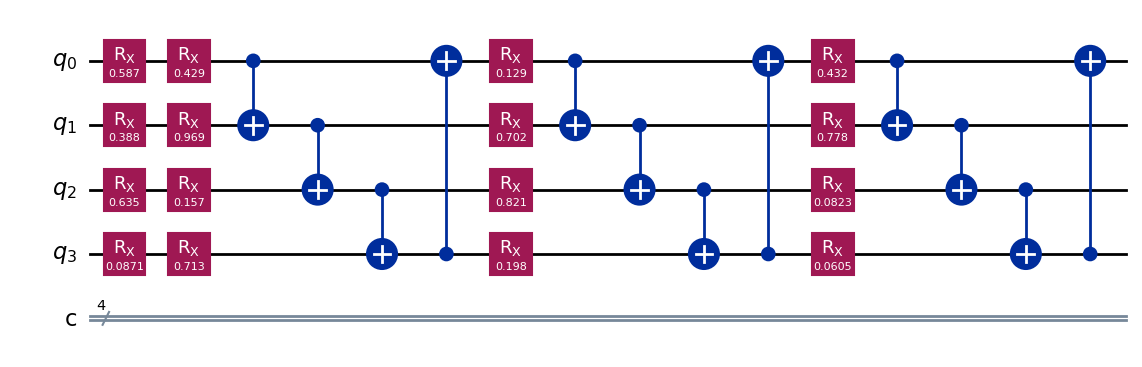

In [4]:
c.draw(output="mpl", style="default", plot_barriers=False)